# Fake News detection with tensorflow and nltk using LSTMs

In [6]:
# !rm -r /kaggle/working

rm: cannot remove '/kaggle/working': Device or resource busy


In [1]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_score, recall_score,
    roc_curve, roc_auc_score, RocCurveDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm


plt.style.use("ggplot")

# Original LSTM+ multimodal model

## Load data with features

In [8]:
!wget https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint3.zip && unzip -o -d data train-checkpoint3.zip

--2023-04-18 16:55:37--  https://github.com/ZetrextJG/MLProject1_FakeNewsDetection/raw/main/train-checkpoint3.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint3.zip [following]
--2023-04-18 16:55:37--  https://media.githubusercontent.com/media/ZetrextJG/MLProject1_FakeNewsDetection/main/train-checkpoint3.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85963394 (82M) [application/zip]
Saving to: ‘train-checkpoint3.zip’

train-checkpoint3.z 100%[===================>]  81.98M   223MB/s    in 0.4s    

2023-04-18 16:5

In [2]:
df = pd.read_csv("/kaggle/working/data/train-checkpoint3.csv", index_col=False)

In [3]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [4]:
df.head()

,text,text_norm,gulpease_index,smog_index,mean_word_len,real
0,isis leader ‘hiding in mosul’ as troops storm ...,"['isi', 'leader', 'hiding', 'mosul', 'troop', ...",51.2,12.9,5.808260,0.0
1,former speaker john boehner goes low…calls two...,"['former', 'speaker', 'john', 'boehner', 'go',...",62.3,9.9,5.899160,0.0
2,mh370 search: debris found in reunion may give...,"['mh370', 'search', 'debris', 'found', 'reunio...",51.0,13.1,6.231598,1.0
3,a leading us senator: us supporting war in sy...,"['leading', 'u', 'senator', 'u', 'supporting',...",48.0,15.2,6.139583,0.0
4,energy update – collective gridwork fluctuatio...,"['energy', 'update', 'collective', 'gridwork',...",55.8,12.3,6.546789,0.0


In [5]:
df = df.loc[:, df.columns != "text"] # Remove standalone text column

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != "real"], df["real"], random_state=42, shuffle=True, test_size=0.2)

In [7]:
X_train

,text_norm,gulpease_index,smog_index,mean_word_len
32162,"['watch', 'news', 'camera', 'catch', 'drug', '...",45.1,0.0,5.555556
14001,"['state', 'department', 'say', 'find', 'email'...",49.6,12.9,6.414573
35625,"['trump', 'visit', 'asia', 'november', 'north'...",50.5,13.8,6.373434
37911,"['colombia', 'farc', 'leader', 'timochenko', '...",48.4,14.0,6.372624
36360,"['trump', 'torture', 'session', 'every', 'day'...",54.7,11.1,5.973684
...,...,...,...,...
6265,"['breaking', 'hispanic', 'men', 'coward', 'bea...",53.0,10.5,5.571429
11284,"['democratic', 'hopeful', 'sander', 'clinton',...",51.5,13.3,6.394256
38158,"['france', 'say', 'saudi', 'coalition', 'must'...",48.5,12.5,6.228070
860,"['palestinian', 'call', 'emergency', 'meeting'...",57.5,13.7,6.363636


In [8]:
X_train.describe()

,gulpease_index,smog_index,mean_word_len
count,34042.000000,34042.000000,34042.000000
mean,52.411480,11.969294,6.101352
std,5.576825,3.484700,0.396024
min,-47.900000,0.000000,3.649660
25%,49.000000,11.200000,5.877928
50%,52.000000,12.500000,6.121951
75%,55.400000,13.800000,6.352941
max,115.000000,28.600000,9.333333


In [9]:
X_train.dtypes

text_norm          object
gulpease_index    float64
smog_index        float64
mean_word_len     float64
dtype: object

In [10]:
y_train.describe()

count    34042.000000
mean         0.439134
std          0.496289
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: real, dtype: float64

Data looks good to create a model

## Final data processing (before model)

I expect a pandas DF that has the columns
- text_norm - Array of splitted and lemmatized words (English only)
- gulpease_index - ...
- smog_index - ...
- mean_word_len - Mean of lengths of words in the text_norm array

In [11]:
X_train.head()

,text_norm,gulpease_index,smog_index,mean_word_len
32162,"['watch', 'news', 'camera', 'catch', 'drug', '...",45.1,0.0,5.555556
14001,"['state', 'department', 'say', 'find', 'email'...",49.6,12.9,6.414573
35625,"['trump', 'visit', 'asia', 'november', 'north'...",50.5,13.8,6.373434
37911,"['colombia', 'farc', 'leader', 'timochenko', '...",48.4,14.0,6.372624
36360,"['trump', 'torture', 'session', 'every', 'day'...",54.7,11.1,5.973684


In [18]:
MAX_VOCAB = 20000
MAX_LEN = 256

In [35]:
class ModelInputCreator(BaseEstimator, TransformerMixin):
    def __init__(self, max_vocab: int, max_len: int, texts_column: str, numerical_columns: List[str]):
        self.max_vocab = max_vocab
        self.max_len = max_len
        self.texts_column = texts_column
        self.numerical_columns = numerical_columns
        self.scaler = StandardScaler()
        self.tokenizer = Tokenizer(num_words=MAX_VOCAB)
        
    def fit(self, df: pd.DataFrame):
        df = df.reset_index(drop=True)
        self.tokenizer.fit_on_texts(df[self.texts_column])
        self.scaler.fit(df[self.numerical_columns])
        return self
    
    def transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        text_sequences = self.tokenizer.texts_to_sequences(df[self.texts_column])
        text_sequences = pad_sequences(text_sequences, padding="post", maxlen=MAX_LEN)
        numerical = self.scaler.transform(df[self.numerical_columns])
        return (text_sequences, numerical)
    
    def fit_transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        self.fit(df)
        return self.transform(df)

In [20]:
input_creator = ModelInputCreator(
    max_vocab = MAX_VOCAB,
    max_len = MAX_LEN,
    texts_column = "text_norm",
    numerical_columns = ["gulpease_index", "smog_index", "mean_word_len"]
)

In [21]:
X_train_transformed = input_creator.fit_transform(X_train)

In [22]:
X_train_transformed

(array([[ 270,   36, 1742, ...,    0,    0,    0],
        [ 815,   97,  989, ...,  285, 2645,   80],
        [ 163,    4,  312, ...,  602,   42,    2],
        ...,
        [ 890,   16,  418, ...,    0,    0,    0],
        [ 939,  142, 1354, ...,    0,    0,    0],
        [ 603, 1808,   16, ...,    0,    0,    0]], dtype=int32),
 array([[-1.31106621, -3.4348642 , -1.37820918],
        [-0.50414367,  0.26708755,  0.79092515],
        [-0.34275916,  0.52536325,  0.68704293],
        ...,
        [-0.7013914 ,  0.15229835,  0.31998076],
        [ 0.91245367,  0.49666595,  0.66230363],
        [-0.89863913,  0.61145515,  0.45234232]]))

# RNN Model

## Model building

In [35]:
text_input = tf.keras.Input(shape=(MAX_LEN,), name="text_input")
text_features = tf.keras.layers.Embedding(MAX_VOCAB, 128)(text_input)

text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(text_features)
text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(text_features)

num_input = tf.keras.Input(shape=(3,), name="num_input")
num_features = tf.keras.layers.Dense(32, activation='relu')(num_input)

merged = tf.keras.layers.concatenate([text_features, num_features])
merged = tf.keras.layers.Dense(8)(merged)
merged = tf.keras.layers.Dropout(0.5)(merged)
output = tf.keras.layers.Dense(1)(merged)

model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 256, 128)     2560000     ['text_input[0][0]']             
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 256, 128)    98816       ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 num_input (InputLayer)         [(None, 3)]          0           []                         

## Model fitting

In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1022/1022 [==============================] - 134s 124ms/step - loss: 0.3776 - accuracy: 0.8214 - val_loss: 0.1970 - val_accuracy: 0.9283
Epoch 2/10
1022/1022 [==============================] - 60s 59ms/step - loss: 0.1655 - accuracy: 0.9452 - val_loss: 0.1549 - val_accuracy: 0.9421
Epoch 3/10
1022/1022 [==============================] - 47s 46ms/step - loss: 0.1115 - accuracy: 0.9650 - val_loss: 0.1360 - val_accuracy: 0.9501
Epoch 4/10
1022/1022 [==============================] - 43s 42ms/step - loss: 0.0726 - accuracy: 0.9793 - val_loss: 0.1517 - val_accuracy: 0.9580
Epoch 5/10
1022/1022 [==============================] - 40s 39ms/step - loss: 0.0590 - accuracy: 0.9831 - val_loss: 0.1548 - val_accuracy: 0.9507


Sometimes you have to run model building and fitting a couple of times to get desired accuracy.

Best Epoch: Epoch 4/10

1022/1022 [==============================] - 42s 41ms/step - loss: 0.0843 - accuracy: 0.9766 - val_loss: 0.1359 - val_accuracy: 0.9551

## Training Visualization

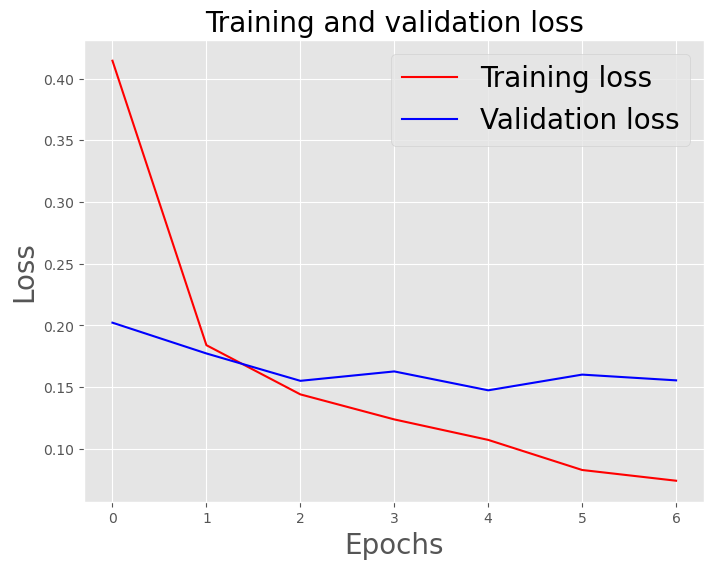

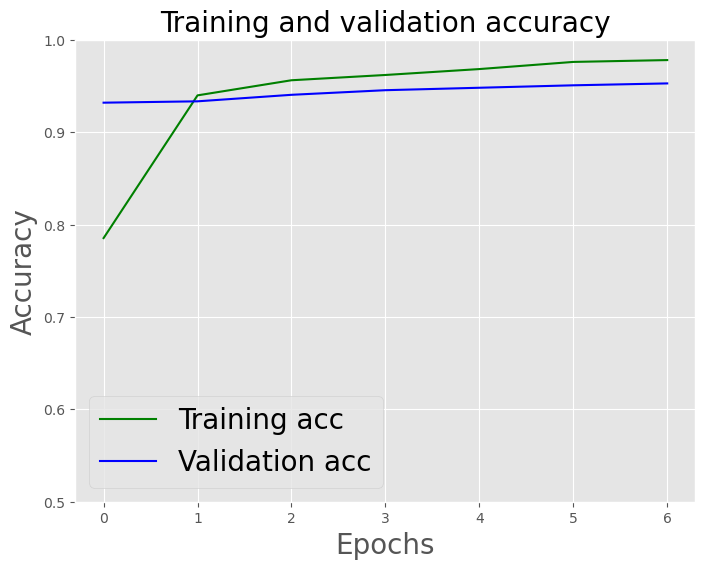

In [25]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

## Testing

Evaluation of the testing set:

In [33]:
X_test_transformed = input_creator.transform(X_test)

In [34]:
model.evaluate(X_test_transformed, y_test)

266/266 [==============================] - 4s 15ms/step - loss: 0.1422 - accuracy: 0.9477


[0.1422223150730133, 0.9477147459983826]

In [28]:
y_pred = model.predict(X_test_transformed)
roc05 = (y_pred > 0.5) * 1

266/266 [==============================] - 5s 14ms/step


### Confusion Matrix

In [ ]:
matrix = confusion_matrix(roc05, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel("Predicted Labels", size=20)
ax.set_ylabel("True Labels", size=20)
ax.set_title("Confusion Matrix", size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [ ]:
print(classification_report(y_test, roc05))

### ROC Curve

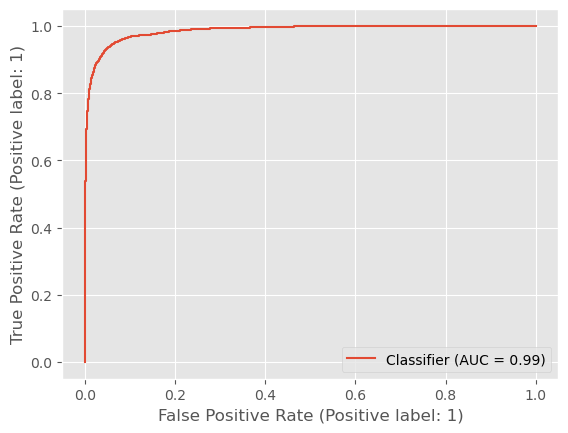

In [38]:
RocCurveDisplay.from_predictions(y_test, y_pred, name="Base RNN model")

# Model optimalization

In [42]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

## Check with additional hidden layer

In [43]:
text_input = tf.keras.Input(shape=(MAX_LEN,), name="text_input")
text_features = tf.keras.layers.Embedding(MAX_VOCAB, 128)(text_input)

text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(text_features)
text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(text_features)
text_features = tf.keras.layers.Dense(64, activation="relu")(text_features)

num_input = tf.keras.Input(shape=(3,), name="num_input")
num_features = tf.keras.layers.Dense(16, activation='relu')(num_input)

merged = tf.keras.layers.concatenate([text_features, num_features])
merged = tf.keras.layers.Dense(8)(merged)
merged = tf.keras.layers.Dropout(0.5)(merged)
output = tf.keras.layers.Dense(1)(merged)

model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)

In [44]:
X_train_transformed = input_creator.transform(X_train)
X_test_transformed = input_creator.transform(X_test)

In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.fit(X_train_transformed, y_train, epochs=10, validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1022/1022 [==============================] - 94s 84ms/step - loss: 0.3008 - accuracy: 0.8605 - val_loss: 0.1665 - val_accuracy: 0.9336
Epoch 2/10
1022/1022 [==============================] - 50s 49ms/step - loss: 0.1240 - accuracy: 0.9596 - val_loss: 0.1536 - val_accuracy: 0.9419
Epoch 3/10
1022/1022 [==============================] - 41s 40ms/step - loss: 0.0756 - accuracy: 0.9778 - val_loss: 0.1517 - val_accuracy: 0.9486
Epoch 4/10
1022/1022 [==============================] - 39s 38ms/step - loss: 0.0479 - accuracy: 0.9862 - val_loss: 0.1851 - val_accuracy: 0.9460
Epoch 5/10
1022/1022 [==============================] - 40s 39ms/step - loss: 0.0298 - accuracy: 0.9916 - val_loss: 0.1926 - val_accuracy: 0.9507


In [54]:
model.evaluate(X_test_transformed, y_test)

266/266 [==============================] - 4s 15ms/step - loss: 0.1553 - accuracy: 0.9482


[0.15534283220767975, 0.9481847286224365]

In [48]:
y_pred = model.predict(X_test_transformed)

266/266 [==============================] - 5s 15ms/step


In [53]:
roc_auc_score(y_test, y_pred)

0.9892941317753194

## Grid Search

In [11]:
MAX_VOCAB = 20000
MAX_LEN = 256

In [12]:
class ModelInputCreator(BaseEstimator, TransformerMixin):
    def __init__(self, max_vocab: int, max_len: int, texts_column: str, numerical_columns: List[str]):
        self.max_vocab = max_vocab
        self.max_len = max_len
        self.texts_column = texts_column
        self.numerical_columns = numerical_columns
        self.scaler = StandardScaler()
        self.tokenizer = Tokenizer(num_words=MAX_VOCAB)
        
    def fit(self, df: pd.DataFrame):
        df = df.reset_index(drop=True)
        self.tokenizer.fit_on_texts(df[self.texts_column])
        self.scaler.fit(df[self.numerical_columns])
        return self
    
    def transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        text_sequences = self.tokenizer.texts_to_sequences(df[self.texts_column])
        text_sequences = pad_sequences(text_sequences, padding="post", maxlen=MAX_LEN)
        numerical = self.scaler.transform(df[self.numerical_columns])
        return (text_sequences, numerical)
    
    def fit_transform(self, df: pd.DataFrame) -> Tuple:
        df = df.reset_index(drop=True)
        self.fit(df)
        return self.transform(df)

In [13]:
input_creator = ModelInputCreator(
    max_vocab = MAX_VOCAB,
    max_len = MAX_LEN,
    texts_column = "text_norm",
    numerical_columns = ["gulpease_index", "smog_index", "mean_word_len"]
)

In [14]:
X_train_search = input_creator.fit_transform(X_train)

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [16]:
import keras_tuner as kt

In [17]:
def create_hyper_model(hp):
    text_input = tf.keras.Input(shape=(MAX_LEN,), name="text_input")
    text_features = tf.keras.layers.Embedding(MAX_VOCAB, 128)(text_input)

    text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(text_features)
    text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(text_features)
    text_features = tf.keras.layers.Dense(
        hp.Choice("units_text", [32, 64]),
        activation="relu"
    )(text_features)

    num_input = tf.keras.Input(shape=(3,), name="num_input")
    num_features = tf.keras.layers.Dense(
        hp.Choice("units_num", [8, 16]),
        activation='relu'
    )(num_input)

    merged = tf.keras.layers.concatenate([text_features, num_features])
    merged = tf.keras.layers.Dense(
        hp.Choice("units_concat", [8, 16]),
        activation="relu"
    )(merged)
    merged = tf.keras.layers.Dropout(0.5)(merged)
    output = tf.keras.layers.Dense(1)(merged)

    model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    
    return model

In [18]:
hp = kt.HyperParameters()
batch_size = hp.Choice("batch_size", [30, 40, 50])
tuner = kt.RandomSearch(
    create_hyper_model,
    objective='val_loss',
    hyperparameters = hp,
    max_trials=24)

In [19]:
results = tuner.search(X_train_search, y_train, epochs=10, validation_split=0.1, batch_size=batch_size, shuffle=True, callbacks=[early_stop])

Trial 18 Complete [00h 05m 18s]
val_loss: 0.16101664304733276

Best val_loss So Far: 0.12511205673217773
Total elapsed time: 00h 05m 18s


In [28]:
tuner.results_summary(num_trials=3)

Results summary
Results in ./untitled_project
Showing 3 best trials
Trial summary
Hyperparameters:
batch_size: 40
units_text: 64
units_num: 16
units_concat: 16
Score: 0.12511205673217773
Trial summary
Hyperparameters:
batch_size: 40
units_text: 32
units_num: 16
units_concat: 16
Score: 0.1350780576467514
Trial summary
Hyperparameters:
batch_size: 30
units_text: 32
units_num: 16
units_concat: 16
Score: 0.13561560213565826


In [30]:
tuner.get_best_hyperparameters(num_trials=3)

In [ ]:
X_test_transformed = input_creator.transform(X_test)

In [ ]:
theoretical_best_model = tuner.get_best_models(num_models=1)[0]
theoretical_best_model.evaluate(X_test_transformed, y_test)

In [42]:
results = []
for i, params in enumerate(tuner.get_best_hyperparameters(num_trials=3)):
    param_dict = {
        "units_text": params.get("units_text"),
        "units_num": params.get("units_num"),
        "units_concat": params.get("units_concat"),
        "batch_size": params.get("batch_size")
    }
    results.append({
        "name": f"model{i}",
        "params": param_dict
    })

In [40]:
results

[{'name': 'model0',
  'params': {'units_text': 64,
   'units_num': 16,
   'units_concat': 16,
   'batch_size': 40}},
 {'name': 'model1',
  'params': {'units_text': 32,
   'units_num': 16,
   'units_concat': 16,
   'batch_size': 40}},
 {'name': 'model2',
  'params': {'units_text': 32,
   'units_num': 16,
   'units_concat': 16,
   'batch_size': 30}}]

In [69]:
results_processed = []
for record in results:
    name = record["name"]
    params = record["params"]
    results_processed.append((name, *params.values()))
results_processed = pd.DataFrame(results_processed)
results_processed.columns = ("name", "dense_units_text", "dense_units_num", "dense_units_concat", "batch_size")

In [70]:
results_processed

,name,dense_units_text,dense_units_num,dense_units_concat,batch_size
0,model0,64,16,16,40
1,model1,32,16,16,40
2,model2,32,16,16,30


In [72]:
results_processed.to_csv("models-for-cv.csv")

## Models crossvalidation

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [37]:
MAX_VOCAB = 20000
MAX_LEN = 256

In [13]:
def create_model(units_text, units_num, units_concat):
    text_input = tf.keras.Input(shape=(MAX_LEN,), name="text_input")
    text_features = tf.keras.layers.Embedding(MAX_VOCAB, 128)(text_input)

    text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(text_features)
    text_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(text_features)
    text_features = tf.keras.layers.Dense(
        units_text,
        activation="relu"
    )(text_features)

    num_input = tf.keras.Input(shape=(3,), name="num_input")
    num_features = tf.keras.layers.Dense(
        units_num,
        activation='relu'
    )(num_input)

    merged = tf.keras.layers.concatenate([text_features, num_features])
    merged = tf.keras.layers.Dense(
        units_concat,
        activation="relu"
    )(merged)
    merged = tf.keras.layers.Dropout(0.5)(merged)
    output = tf.keras.layers.Dense(1)(merged)

    model = tf.keras.Model(inputs=[text_input, num_input], outputs=output)
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
    
    return model

In [14]:
cv_results = {
    "model0": [],
    "model1": [],
    "model2": []
}

In [28]:
cv_results = np.load('cv_results.npy',allow_pickle='TRUE').item()

In [33]:
np.save("cv_results.npy", cv_results)

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for i, (train_index, test_index) in enumerate(kf.split(df)):
    if i < 3: continue # skip already coverted folds
    input_creator = ModelInputCreator(
        max_vocab = MAX_VOCAB,
        max_len = MAX_LEN,
        texts_column = "text_norm",
        numerical_columns = ["gulpease_index", "smog_index", "mean_word_len"]
    )
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    print("  Preprocessing data ...")
    X_fold_train = input_creator.fit_transform(df.loc[:, df.columns != "real"].iloc[train_index])
    X_fold_test = input_creator.transform(df.loc[:, df.columns != "real"].iloc[test_index])
    y_fold_train =  df["real"].iloc[train_index]
    y_fold_test =  df["real"].iloc[test_index]

    print("  Evaluating model:")
    for records in results:
        name = records["name"]
        params = records["params"]
        print(f"    Training model {name}")
        
        model = create_model(params["units_text"], params["units_num"], params["units_concat"])
        model.fit(X_fold_train, y_fold_train, epochs=10, validation_split=0.1, batch_size=params["batch_size"], callbacks=[early_stop])
        
        print(f"    Evaluating model {name}")
        eval_res = model.evaluate(X_fold_test, y_fold_test)
        y_fold_pred = model.predict(X_fold_test)
        auc_score = roc_auc_score(y_fold_test, y_fold_pred)
        
        cv_results[name].append((eval_res, auc_score))


Fold 3:
  Train: index=[    0     3     4 ... 42550 42551 42552]
  Test:  index=[    1     2     5 ... 42544 42546 42547]
  Preprocessing data ...
  Evaluating model:
    Training model model0
Epoch 1/10
766/766 [==============================] - 120s 135ms/step - loss: 0.4555 - accuracy: 0.7579 - val_loss: 0.2208 - val_accuracy: 0.9198
Epoch 2/10
766/766 [==============================] - 50s 65ms/step - loss: 0.1948 - accuracy: 0.9362 - val_loss: 0.1565 - val_accuracy: 0.9421
Epoch 3/10
766/766 [==============================] - 40s 52ms/step - loss: 0.1320 - accuracy: 0.9563 - val_loss: 0.1641 - val_accuracy: 0.9498
Epoch 4/10
766/766 [==============================] - 36s 46ms/step - loss: 0.0959 - accuracy: 0.9685 - val_loss: 0.1799 - val_accuracy: 0.9486
    Evaluating model model0
266/266 [==============================] - 5s 14ms/step
    Training model model1
Epoch 1/10
766/766 [==============================] - 81s 96ms/step - loss: 0.5253 - accuracy: 0.7237 - val_loss: 0.309

In [42]:
cv_results

{'model0': [([0.14839619398117065, 0.9440723657608032], 0.9868337075543502),
  ([0.14835602045059204, 0.9431257247924805], 0.9862102931690577),
  ([0.14625023305416107, 0.9485311508178711], 0.9856247196315053),
  ([0.14728879928588867, 0.9444183111190796], 0.9859101544472233),
  ([0.14572347700595856, 0.9448883533477783], 0.9877679622678623)],
 'model1': [([0.14301377534866333, 0.9499471187591553], 0.9891748654205927),
  ([0.13890030980110168, 0.9497121572494507], 0.9873711520331451),
  ([0.15656369924545288, 0.9513513445854187], 0.9871027638277556),
  ([0.16379423439502716, 0.9462984800338745], 0.9870187484864369),
  ([0.15658316016197205, 0.9450058937072754], 0.9866007689287852)],
 'model2': [([0.15248462557792664, 0.9416049718856812], 0.9842608804703546),
  ([0.1436273604631424, 0.9506521224975586], 0.9885370874954659),
  ([0.13772660493850708, 0.9520564079284668], 0.9883118237646303),
  ([0.14155615866184235, 0.9511163234710693], 0.9874064836230794),
  ([0.14992763102054596, 0.9445

In [52]:
parsered_cv_results = []
for key, values in cv_results.items():
    for value in values:
        test_loss, test_acc = value[0]
        roc_auc = value[1]
        gini = 2 * value[1] - 1
        parsered_cv_results.append((key, test_loss, test_acc, roc_auc, gini))
df_cv_results = pd.DataFrame(parsered_cv_results)
df_cv_results.columns = ("name", "loss", "accuracy", "roc_auc", "gini")

In [53]:
df_cv_results

,name,loss,accuracy,roc_auc,gini
0,model0,0.148396,0.944072,0.986834,0.973667
1,model0,0.148356,0.943126,0.986210,0.972421
2,model0,0.146250,0.948531,0.985625,0.971249
3,model0,0.147289,0.944418,0.985910,0.971820
4,model0,0.145723,0.944888,0.987768,0.975536
5,model1,0.143014,0.949947,0.989175,0.978350
6,model1,0.138900,0.949712,0.987371,0.974742
7,model1,0.156564,0.951351,0.987103,0.974206
8,model1,0.163794,0.946298,0.987019,0.974037
9,model1,0.156583,0.945006,0.986601,0.973202


In [66]:
df_cv_results.to_csv("cross-validation-results.csv")

Text(0.5, 1.0, 'Loss distribution in test per model')

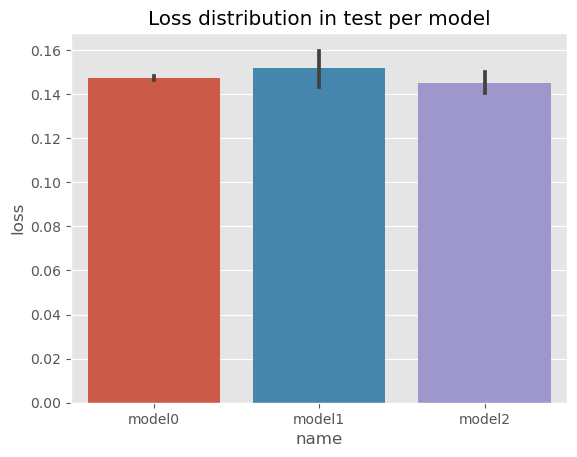

In [60]:
sns.barplot(df_cv_results, x = "name", y = "loss")
plt.title("Loss distribution in test per model")

(0.9, 1.0)

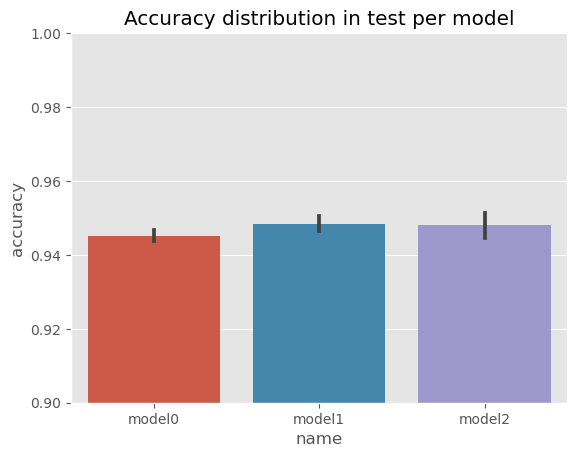

In [64]:
sns.barplot(df_cv_results, x = "name", y = "accuracy")
plt.title("Accuracy distribution in test per model")
plt.ylim((0.90,1))

(0.9, 1.0)

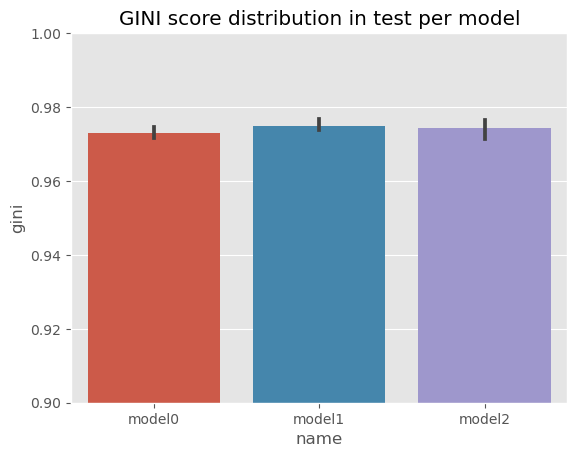

In [65]:
sns.barplot(df_cv_results, x = "name", y = "gini")
plt.title("GINI score distribution in test per model")
plt.ylim((0.90,1))